In [ ]:
import argparse
import torch
import pandas as pd
import numpy as np
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from tqdm import tqdm
import matplotlib.pyplot as plt


In [ ]:
# Open High Low Close
train_data=pd.read_csv('training.csv',header=None)

open_mean=train_data.mean()[0]
open_std=train_data.std()[0]
# print(train_data[0])
# train_data.head()
# train_data.shape

In [ ]:
def get_data(df, days_to_train=2, days_to_pred=1):
    # 用前三天預測當天
    X=[]
    Y=[]

    df=df.apply(lambda x:(x-x.mean())/ x.std())
    
    for i in range(df.shape[0]-days_to_train):
        X.append(np.array(df.iloc[i:(i+days_to_train)],dtype=np.float32))
        Y.append(np.array(df.iloc[i+days_to_train,0],dtype=np.float32))

    return np.array(X), np.array(Y)

class DataSet(Dataset):

    def __init__(self,a, b, trans):
        self.train=a
        self.valid=b
        self.transform=trans

    def __getitem__(self, index) :
        x=self.train[index]
        y=self.valid[index]

        x=self.transform(x)
        # y=self.transform(y)

        return x, y

    def __len__(self):

        return len(self.train)

In [ ]:
X, Y=get_data(train_data)
# print(X)

train_x, train_y=X[:int(len(X)*0.8)], Y[:int(len(Y)*0.8)]
valid_x, valid_y=X[int(len(X)*0.8):], Y[int(len(Y)*0.8):]

transform=transforms.Compose([
    transforms.ToTensor(),
])
train_loader=DataLoader(dataset=DataSet(train_x, train_y, transform),batch_size=2,shuffle=True)
valid_loader=DataLoader(dataset=DataSet(valid_x, valid_y, transform),batch_size=2,shuffle=True)

print(len(train_x), len(valid_x))


In [ ]:
class LSTM(torch.nn.Module):
    def __init__(self, input=4, hidden_size=32, output=1):
        # Input of LSTM : batch, sequence_len, input_size
        super(LSTM, self).__init__()

        self.rnn=torch.nn.LSTM(input, hidden_size, batch_first=True)
        self.linear=torch.nn.Linear(hidden_size, output)

    def forward(self,x):
        out, (hidden, cell) = self.rnn(x)
        a, b, c = hidden.shape
        # print(hidden.reshape(a*b,c).shape)
        out = self.linear(hidden.reshape(a*b,c))
        
        return out

# LSTM=torch.nn.LSTM(4,32,batch_first=True)

In [ ]:
EPOCH = 50
LR = 0.001

device = 'cpu'
if torch.cuda.is_available(): # 若想使用 cuda 且可以使用 cuda
    device = 'cuda'

print('Using %s'%device)

In [ ]:
model = LSTM()
model=model.to(device)
criterion=torch.nn.MSELoss()
optimizer=torch.optim.Adam(model.parameters(), lr = LR)

print(model)

In [ ]:
# Train model

preds=[]
targets=[]

for i in range(EPOCH):
    print('============EPOCH {}============'.format(i+1))
    
    model.train()
    train_loss=0
    for _, (data, label) in enumerate(tqdm(train_loader)):
        data, label = data.to(device), label.to(device)

        optimizer.zero_grad()
        pred=model(data.squeeze())
        label=label.unsqueeze(1)

        loss=criterion(pred, label)

        loss.backward()
        optimizer.step()

        train_loss+=loss.item()
        # print(label.unsqueeze(1).shape)
        # print(pred.shape)
        # break
        
    

    # Validate model
    model.eval()
    valid_loss = 0

    with torch.no_grad():
        for _, (data, label) in enumerate(tqdm(valid_loader)):
            data, label = data.to(device), label.to(device)

            pred=model(data.squeeze())
            # print(data.shape)
            label=label.unsqueeze(1)

            loss = criterion(pred, label)

            valid_loss+=loss.item()

            preds.extend(pred.squeeze().tolist())
            targets.extend(label.squeeze().tolist())
            # break
        
        print("Train loss:%s" % train_loss)
        print("Valid loss:%s" % valid_loss)

torch.save(model,'LSTM.pt')

# print(len(preds))
# print(len(targets))

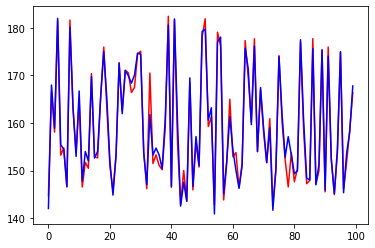

In [390]:
# Test

plt.plot([(i*open_std)+open_mean for i in preds[:100]],'r',label='Prediction')
plt.plot([(i*open_std)+open_mean for i in targets[:100]],'b',label='Real data')
plt.show()

In [408]:
# Test data
test_data=pd.read_csv('testing.csv',header=None)
test_mean, test_std = test_data.mean()[0], test_data.std()[0]
open_price=test_data[0]
test_data=test_data.apply(lambda x:(x-x.mean())/ x.std())

X=[]
days_to_used=2
for i in range(test_data.shape[0]-days_to_used):
    X.append(np.array(test_data.iloc[i:(i+days_to_used)],dtype=np.float32))
test_set=np.array(X)
# print(test_set.shape)
test_set=transform(test_set)
test_set=test_set.permute(1, 2, 0)
# print(test_set.shape)
test_set=test_set.to(device)

# for _, (data, label) in enumerate((valid_loader)):
#     print(data.shape)
#     break
model.eval()
with torch.no_grad():
    test_pred=model(test_set)
test_pred=test_pred.squeeze().tolist()
test_pred.insert(0,0)
test_pred.insert(0,0)
# print(test_pred)

# plt.plot([(i*test_std)+test_mean for i in test_pred],'r',label='Prediction')
# plt.plot(open_price,'b',label='Real data')
# plt.show()

actions=[]
unit=0
my_price=0
for i in range(len(open_price)-1):
    
    if i < 1:
        actions.append(0)
        continue

    today_price=open_price[i]
    pred_price=test_pred[i+1]*test_std+test_mean
    if my_price < pred_price and unit == 1:
        # Sell
        actions.append(-1)
        unit-=1
    elif today_price > pred_price and unit == 0:
        # Buy
        actions.append(1)
        my_price=open_price[i+1]
        unit+=1
    else:
        actions.append(0)
    # print(i)

submission=pd.DataFrame({
    'Action':actions
})
submission.to_csv('output.csv',header=None, index=False)

# print(submission)

